In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
# import seaborn as sns
from localtsfresh.tsfresh import extract_features, extract_relevant_features, select_features
from localtsfresh.tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from pandas import DataFrame
import pandas as pd
import numpy as np
import os
import math

import logging

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import butter, lfilter, lfilter_zi
from numpy import linalg as LA
from xgboost import XGBClassifier
import copy
from collections import Counter
from sklearn import neighbors
from sklearn.svm import SVC 

# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

#根据Win，生成DataFrame格式中的Time列
def getTimeColumn(win):
    time=np.arange(win)
    for idx in range(1, sensornum):
        timetmp=np.arange(win)
        time=np.concatenate((time, timetmp), axis=0)
    time.shape=(len(time),1)
    return time

#根据Win和数据，生成DataFrame格式中的kind和value列
def getKindValueColumn(sd, win):
    for i in range(sensornum):
        kind=i*np.ones((win, 1),dtype=int)
        sensorcols=sd[i]
        sensorcols.shape=(win, 1)
        sdata=np.column_stack((kind, sensorcols))
        if i==0:
            sensorframe=sdata
        else:
            sensorframe=np.row_stack((sensorframe, sdata))
    return sensorframe

def getIdColumn(num, win):
    for i in range(num):
        if i==0:
            idary=0*np.ones((sensornum*win, 1))
        else:
            idary=np.row_stack((idary, i*np.ones((sensornum*win, 1))))
    return idary

def getDataLabelColumn(dataary,label, num, win):
    for i in range(filenum):
        if i==0:
            y=label[travel[i]][:num]
            data=dataary[travel[i]][:num*win*sensornum]
        else:
            y=np.row_stack((y, label[travel[i]][:num]))
            data=np.row_stack((data, dataary[travel[i]][:num*win*sensornum]))
    y.shape=(len(y),)
    y=pd.Series(y)
    return data, y


#读取所有数据，结果是字典，分别存储六种运动的传感器读数矩阵，每个矩阵的三列分别是time, kind, value
def loadData(win, step, fs):
    labeldict={}
    datadict={}
    files = os.listdir('/home/hadoop/data')
    if step<=win:
        for i in range(0, filenum):
            with open('/home/hadoop/data/%s' % files[i], 'r') as f:
                sensordata=np.loadtxt(f, delimiter=",")[::2, :]
                max_num=int((len(sensordata)-win)/step)+1
                
                ########## feature extraction ###########
                sensordata = np.delete(sensordata, np.s_[:3], 1)
                sensordata[:, 2] = sensordata[:, 2] - 9.8
                #mi = LA.norm(sensordata, 2, axis=1)
                #sma = np.sum(np.abs(sensordata), 1)
                #velo = calcVelo(sensordata[:,:2], fs, win)
                #sensordata = np.c_[sensordata, mi, sma]
                
                #loadDataPlot(sensordata, i)

                ########## filter ############
                #fltr2(sensordata, cutOff=15, fs=fs, order=5)
                #########################################
                
                for j in range(0, max_num):
                    start_idx=step*j
                    end_idx=step*j+win
                    sd=sensordata[start_idx:end_idx,:]
                    sd=sd.transpose()
                        
                    time=getTimeColumn(win)
                    kindvalue=getKindValueColumn(sd, win)
                    travary=np.column_stack((time, kindvalue ))

                    if j == 0:
                        dataarray=travary
                    else:
                        dataarray=np.concatenate((dataarray, travary), axis=0)  

                labeldict[travel[i]]=i*np.ones((max_num, 1), dtype=int)
                datadict[travel[i]]=dataarray
                print(files[i]+" loaded!")
        use_num_max=filenum*max_num
        return datadict, labeldict, use_num_max
    else:
        raise IOError('\'step\' of slide window shoud be less than \'win\'')

#从所有数据dataary和其标签label中，选出总数为num的样本，每个类别选num/sensornum个样本。
def genTrainSample(dataary, label, num, win):
    idary=getIdColumn(num, win)
    labelnum=int(num/filenum) ;
    data, y=getDataLabelColumn(dataary, label, labelnum, win)
    data=np.column_stack((idary, data))
    dataframe = DataFrame(data, columns=['id', 'time', 'kind', 'value'])
    return dataframe, y



#画出第idx个样本3个传感器的数据
def plotSample(data, kind, idx, win, use_num):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    tmp=data.iloc[:, -1].values
    for i in range(sensornum):
        plt.subplot(3,2,i+1)
        plt.title(sensor[i] + ' readings')
        begin=kind*win*use_num + idx*win*sensornum + win*i
        end=begin+win-1
        plt.plot(tmp[begin:end])
    plt.show()
    
def loadDataPlot(data, ind):
    plt.figure(ind)
    for i in xrange(0, data.shape[1]):
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.subplot(3,2,i+1)
        plt.plot(data[:, i])
    return

################ Calculate Velocity ###################

def calcVelo(acc, fs, win):
    velo = np.zeros(acc.shape)
    for i in xrange(0, acc.shape[0]):
        if i % win: 
            velo[i] = velo[i-1] + (acc[i-1]+acc[i])/(2*fs)
    return LA.norm(velo, 2, axis=1)
        

################ Butterworth 滤波 ###################

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def fltr(data, win, sensornum, cutOff, fs, order=5): #这个是在滑窗之后滤波的函数
    v = data.iloc[:, -1].values
    b, a = butter_lowpass(cutOff, fs, order)
    zi = np.tile(lfilter_zi(b, a), (sensornum,1))
    for i in xrange(0, v.size, win*sensornum):
        for j in xrange(0, sensornum):
            x = v[i+j*win: i+(j+1)*win]
            y, zi[j]= lfilter(b, a, x, zi=zi[j])
            data.iloc[i+j*win: i+(j+1)*win, -1] = y
    return

def fltr2(sensordata, cutOff, fs, order):  #这个是在数据读取后马上就滤波的函数
    b, a = butter_lowpass(cutOff, fs, order)
    for n in xrange(sensordata.shape[1]):
        zi = lfilter_zi(b, a)
        sensordata[:,n], zi = lfilter(b, a, sensordata[:,n], zi=zi)


localtsfresh_init!
feature_extraction_init
tsfresh_init!


In [102]:
#可修改常量
# 六种出行方式
travel=["bus", "car", "running", "stationary", "subway", "walking"]
# 六个传感器数据
#sensor=["azimath", "pitch", "roll", "mi", "sma"]
sensor=["azimath", "pitch", "roll"]
# 一些常量
filenum=6
#窗口步长大小
#win = [100，200,300,400,500]/sample
win=100
step=win/2            #步长应该小于等于win
#sample = [1,2,3,4,5] 
sampling=2         #采样间隔，注意，win是在采样间隔基础上算的
#使用的样本数量(一个窗口的数据是一个样本)，建议设置成sensornum的倍数
fs = math.ceil(100/sampling)

sensornum=len(sensor)
data, label, use_num_max = loadData(win, step, fs)

print("\n \033[1;33;48m NOTE: use_num should be less than %s"%(use_num_max))

bus_data_set_101 loaded!
car_data_set_103 loaded!
running_data_set_8 loaded!
stationary_data_set_3 loaded!
subway_data_set_102 loaded!
walking_data_set_7 loaded!

  NOTE: use_num should be less than 7290


In [127]:
# 重采样的数据集
data_sr2 = {}
data_sr3 = {}
data_sr4 = {}
data_sr5 = {}
for i in travel:
    data_sr2[i] = data[i][::2]
    data_sr3[i] = data[i][::3]
    data_sr4[i] = data[i][::4]
    data_sr5[i] = data[i][::5]

In [128]:
#取出use_num个样本，并将data转化成tsfresh需要的pandas.DataFrame类型，存储为df；将label转化为特征过滤需要的pandas.Series类型，存储为y
# print(data["bus"].shape)        #data["bus]矩阵三列分别是time, kind, value
# print(label["bus"].shape)       #只有一列，因为sensornum*win条读数才是一个样本，所以label的行数是data的1/(sensornum*win)
use_num = 7200
df, y=genTrainSample(data_sr2, label, use_num, win)

######## Low Pass Filter ##########
#kind=0
#idx=10
#plotSample(df, kind,idx, win, use_num)
#fltr(df, win, sensornum, cutOff=4, fs=fs, order=5) #filter

master_df = df
print(master_df.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

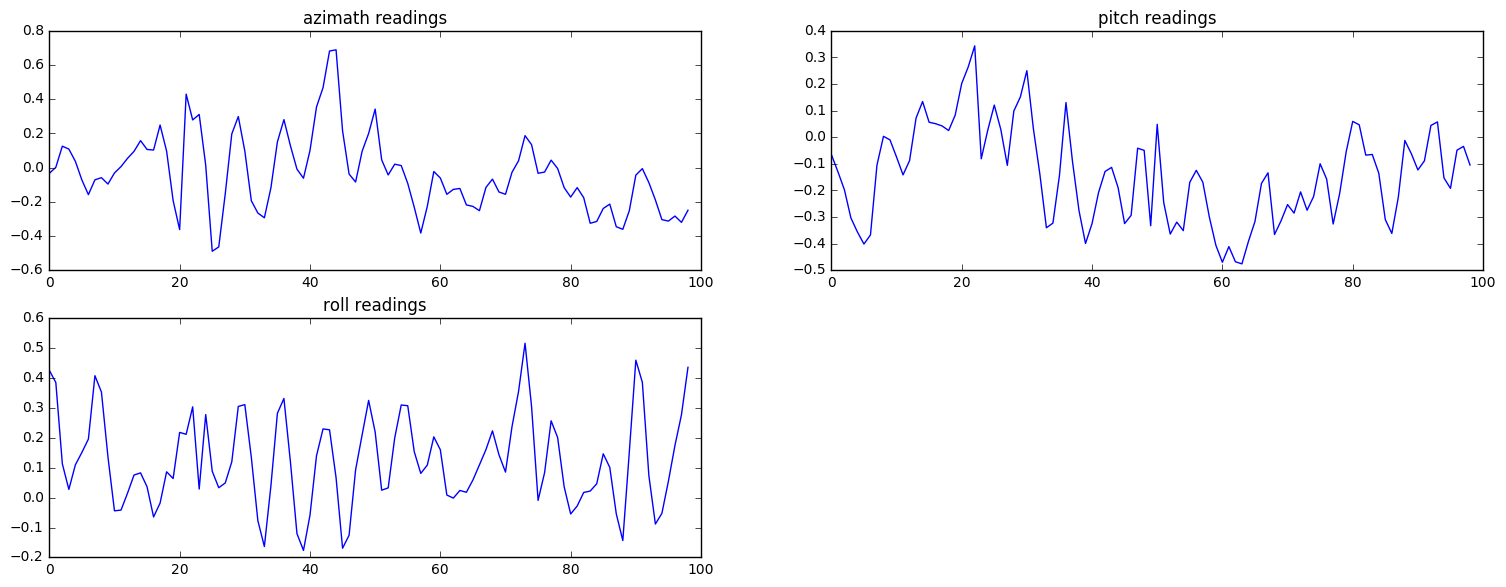

In [104]:
kind=2
idx=100
plotSample(df, kind, idx, win, use_num)

In [105]:
# extraction_settings = ComprehensiveFCParameters()
#extraction_settings = EfficientFCParameters()
# extraction_settings = MinimalFCParameters()
#extraction_settings.update({"fft_dc":None,"fft_mean":None,"fft_var":None,"fft_std":None,"fft_kurt":None,"fft_shape_mean":None,"fft_shape_std":None,"fft_shape_skew":None,"fft_shape_kurt":None})

extraction_settings = {'ar_coefficient': [{'coeff': 0, 'k': 10},
    {'coeff': 1, 'k': 10},
    {'coeff': 2, 'k': 10},
    {'coeff': 3, 'k': 10},
    {'coeff': 4, 'k': 10}],
          'longest_strike_above_mean': None,
          'longest_strike_below_mean': None,
         'mean_abs_change_quantiles': [{'qh': 0.2, 'ql': 0.0},
                                        {'qh': 0.4, 'ql': 0.0},
                                        {'qh': 0.6, 'ql': 0.0},
                                        {'qh': 0.8, 'ql': 0.0},
                                        {'qh': 1.0, 'ql': 0.0},
                                        {'qh': 0.4, 'ql': 0.2},
                                        {'qh': 0.6, 'ql': 0.2},
                                        {'qh': 0.8, 'ql': 0.2},
                                        {'qh': 1.0, 'ql': 0.2},
                                        {'qh': 0.6, 'ql': 0.4},
                                        {'qh': 0.8, 'ql': 0.4},
                                        {'qh': 1.0, 'ql': 0.4},
                                        {'qh': 0.8, 'ql': 0.6},
                                        {'qh': 1.0, 'ql': 0.6},
                                        {'qh': 1.0, 'ql': 0.8}],
          'autocorrelation': [{'lag': 0},{'lag': 1},{'lag': 2},{'lag': 3},{'lag': 4},
                              {'lag': 5},{'lag': 6},{'lag': 7},{'lag': 8},{'lag': 9}],
          'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
          'quantile': [{'q': 0.1},{'q': 0.2},{'q': 0.3},{'q': 0.4},
                       {'q': 0.6},{'q': 0.7},{'q': 0.8},{'q': 0.9}],
          'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}],
          'minimum': None,
          'maximum': None,
          'median': None,
          'sum_values': None,
          'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
                    "fft_dc":None,
                    "fft_mean":None,
                    #"fft_var":None,
                    "fft_std":None,
                    "fft_kurt":None,
                    "fft_shape_mean":None,
                    "fft_shape_std":None,
                    "fft_shape_skew":None,
                    "fft_shape_kurt":None
                      }



In [106]:
%time X = extract_features(master_df, default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");

It is ok!


Feature Extraction: 100%|██████████| 21600/21600 [04:18<00:00, 83.47it/s]


CPU times: user 13.4 s, sys: 1.04 s, total: 14.4 s
Wall time: 4min 27s


In [107]:
%timeit Y = extract_features(master_df.ix[0:(win*3*100-1)], default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");

It is ok!


Feature Extraction: 100%|██████████| 300/300 [00:07<00:00, 39.44it/s]

It is ok!



Feature Extraction: 100%|██████████| 300/300 [00:03<00:00, 77.15it/s]

It is ok!



Feature Extraction: 100%|██████████| 300/300 [00:03<00:00, 88.67it/s]


It is ok!


Feature Extraction: 100%|██████████| 300/300 [00:04<00:00, 70.82it/s]

1 loop, best of 3: 3.56 s per loop


In [108]:
%time Y = extract_features(master_df.ix[0:(win*3*100-1)], default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");

It is ok!


Feature Extraction: 100%|██████████| 300/300 [00:04<00:00, 73.31it/s]


CPU times: user 277 ms, sys: 120 ms, total: 397 ms
Wall time: 4.66 s


In [109]:
##%prun Y = extract_features(master_df.ix[0:(win*3*100-1)], default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");

In [110]:
impute(X)
X.shape

(7200, 183)

In [111]:
for n in X.columns:
    std = np.std(X[n])
    X[n] = (X[n]-np.mean(X[n]))/std if std>0 else X[n]-np.mean(X[n])

In [112]:
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)

In [113]:
mean = 0
for i in xrange(0, 20):
    X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)
    eval_set = [(X_val, y_val)]
    cl = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=2)
    cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
    score = accuracy_score(y_test, cl.predict(X_test))
    print('Loop %d, accuracy=%f' % (i, score))
    mean += score
print('Mean accuracy is %f' % (mean/20))

Loop 0, accuracy=0.943750
Loop 1, accuracy=0.932639
Loop 2, accuracy=0.936806
Loop 3, accuracy=0.954861
Loop 4, accuracy=0.941667
Loop 5, accuracy=0.936111
Loop 6, accuracy=0.949306
Loop 7, accuracy=0.945833
Loop 8, accuracy=0.950000
Loop 9, accuracy=0.940278
Loop 10, accuracy=0.945833
Loop 11, accuracy=0.943056
Loop 12, accuracy=0.952083
Loop 13, accuracy=0.936806
Loop 14, accuracy=0.940278
Loop 15, accuracy=0.940278
Loop 16, accuracy=0.940972
Loop 17, accuracy=0.943750
Loop 18, accuracy=0.946528
Loop 19, accuracy=0.945833
Mean accuracy is 0.943333


# 整体模型

In [114]:
eval_set = [(X_val, y_val)]
cl = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=2)
cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test, cl.predict(X_test))
print('Accuracy of test data is %f' %score)
print(classification_report(y_test, cl.predict(X_test)))
print (pd.crosstab(cl.predict(X_test), y_test, rownames=['actual'], colnames=['preds']))

Accuracy of test data is 0.945833
             precision    recall  f1-score   support

          0       0.88      0.92      0.90       232
          1       0.93      0.91      0.92       253
          2       1.00      0.98      0.99       242
          3       1.00      0.99      0.99       229
          4       0.90      0.90      0.90       245
          5       0.98      0.99      0.98       239

avg / total       0.95      0.95      0.95      1440

preds     0    1    2    3    4    5
actual                              
0       213   13    0    1   15    1
1         5  229    1    1    9    1
2         0    0  237    0    0    1
3         0    1    0  226    0    0
4        13    9    1    1  221    0
5         1    1    3    0    0  236


In [115]:
%timeit cl.predict(X_test.iloc[0:99])

100 loops, best of 3: 6.37 ms per loop


In [116]:
cl1 = RandomForestClassifier()
cl1.fit(X_train, y_train)
score1 = accuracy_score(y_test, cl1.predict(X_test))
print('Accuracy of test data is %f' %score1)
print(classification_report(y_test, cl1.predict(X_test)))
print (pd.crosstab(cl1.predict(X_test), y_test, rownames=['actual'], colnames=['preds']))

Accuracy of test data is 0.911806
             precision    recall  f1-score   support

          0       0.78      0.87      0.82       232
          1       0.89      0.87      0.88       253
          2       0.99      0.95      0.97       242
          3       0.99      0.98      0.98       229
          4       0.89      0.82      0.85       245
          5       0.95      0.99      0.97       239

avg / total       0.91      0.91      0.91      1440

preds     0    1    2    3    4    5
actual                              
0       202   22    2    1   31    1
1        11  220    3    2   12    0
2         0    2  230    0    0    1
3         0    2    0  225    1    0
4        15    6    1    1  200    1
5         4    1    6    0    1  236


In [117]:
%timeit cl1.predict(X_test.iloc[0:99])

1000 loops, best of 3: 1.07 ms per loop


In [118]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_train, y_train)
score2 = accuracy_score(y_test, cl2.predict(X_test))
print('Accuracy of test data is %f' %score2)
print(classification_report(y_test, cl2.predict(X_test)))
print (pd.crosstab(cl2.predict(X_test), y_test, rownames=['actual'], colnames=['preds']))

Accuracy of test data is 0.840278
             precision    recall  f1-score   support

          0       0.70      0.72      0.71       232
          1       0.75      0.72      0.74       253
          2       0.95      0.96      0.95       242
          3       0.98      0.96      0.97       229
          4       0.75      0.76      0.76       245
          5       0.92      0.93      0.92       239

avg / total       0.84      0.84      0.84      1440

preds     0    1    2    3    4    5
actual                              
0       168   32    2    2   32    4
1        28  182    2    5   22    3
2         1    4  232    0    2    5
3         1    3    0  219    1    0
4        27   26    0    3  187    5
5         7    6    6    0    1  222


In [119]:
%timeit cl2.predict(X_test.iloc[0:99])

1000 loops, best of 3: 219 µs per loop


In [120]:
cl3 = neighbors.KNeighborsClassifier()  
cl3.fit(X_train, y_train)
score3 = accuracy_score(y_test, cl3.predict(X_test))
print('Accuracy of test data is %f' %score3)
print(classification_report(y_test, cl3.predict(X_test)))
print (pd.crosstab(cl3.predict(X_test), y_test, rownames=['actual'], colnames=['preds']))

Accuracy of test data is 0.865972
             precision    recall  f1-score   support

          0       0.74      0.84      0.79       232
          1       0.85      0.72      0.78       253
          2       0.98      0.96      0.97       242
          3       0.93      0.97      0.95       229
          4       0.75      0.76      0.75       245
          5       0.97      0.96      0.97       239

avg / total       0.87      0.87      0.87      1440

preds     0    1    2    3    4    5
actual                              
0       196   32    1    3   28    6
1         8  182    0    1   23    1
2         1    2  232    0    1    1
3         2    5    3  222    7    0
4        25   32    1    3  185    1
5         0    0    5    0    1  230
